In [7]:
# Load monthly provider panel
import pandas as pd

panel = pd.read_parquet("../data/processed/provider_panel_all_dates.parquet")

# Feature columns for anomaly detection
feature_cols = [
    # Rolling means
    "mean_daily_claims_30d", "mean_daily_claims_90d",
    "mean_daily_claims_180d", "mean_daily_claims_365d",

    # Rolling volatility
    "claims_std_30d", "claims_std_90d",
    "claims_std_180d", "claims_std_365d",

    # Allowed amount abnormality (economic signal)
    "mean_zscore_allowed_30d", "mean_zscore_allowed_90d",
    "mean_zscore_allowed_180d", "mean_zscore_allowed_365d",

    # Momentum & drift
    "claims_90d_vs_prev90d",
    "zscore_90d_vs_prev90d",

    # Recency
    "days_since_last",
]


panel = panel.dropna(subset=feature_cols).copy()
panel.shape

(10461, 38)

In [15]:
# Run Isolation Forest + LOF + Z-score hybrid
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent 
SRC_DIR = str(PROJECT_ROOT / "src")

if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

from healthcare_signals.model_anomaly import (run_isolation_forest, run_lof, add_zscore_flags, combine_flags)

panel = run_isolation_forest(panel, feature_cols)
panel = run_lof(panel, feature_cols)
panel = add_zscore_flags(panel, [
    "mean_daily_claims_30d",
    "mean_daily_claims_90d",
    "mean_daily_claims_180d",
    "mean_daily_claims_365d",
    "claims_std_90d",
])

panel = combine_flags(panel)

panel.head()

,provider_id,first_activity_dt,last_activity_dt,total_claims_lifetime,n_active_days_lifetime,mean_zscore_lifetime,days_since_last,n_active_days_30d,total_claims_30d,mean_daily_claims_30d,...,mean_daily_claims_90d_z,mean_daily_claims_90d_z_flag,mean_daily_claims_180d_z,mean_daily_claims_180d_z_flag,mean_daily_claims_365d_z,mean_daily_claims_365d_z_flag,claims_std_90d_z,claims_std_90d_z_flag,anomaly_total_flags,anomaly_rank
0,0557475616,2007-10-17,2007-10-17,1,1,0.0,14,1.0,1.0,1.0,...,2.492886,0,1.629459,0,0.954481,0,NaN,0,1,3.0
1,3762822013,2007-10-15,2007-10-15,1,1,0.0,16,1.0,1.0,1.0,...,2.492886,0,1.629459,0,0.954481,0,NaN,0,1,3.0
2,0557475616,2007-10-17,2007-10-17,1,1,0.0,44,0.0,0.0,0.0,...,2.492886,0,1.629459,0,0.954481,0,NaN,0,0,4.0
3,2457354102,2007-11-14,2007-11-14,1,1,0.0,16,1.0,1.0,1.0,...,2.492886,0,1.629459,0,0.954481,0,NaN,0,1,3.0
4,3762822013,2007-10-15,2007-10-15,1,1,0.0,46,0.0,0.0,0.0,...,2.492886,0,1.629459,0,0.954481,0,NaN,0,0,4.0


In [17]:
# Export scored monthly snapshot
panel.to_parquet("../data/processed/provider_panel_scored.parquet", index=False)

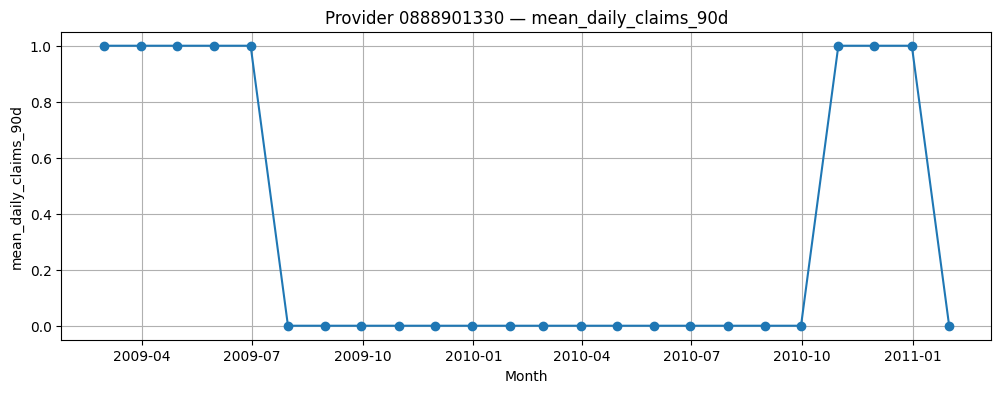

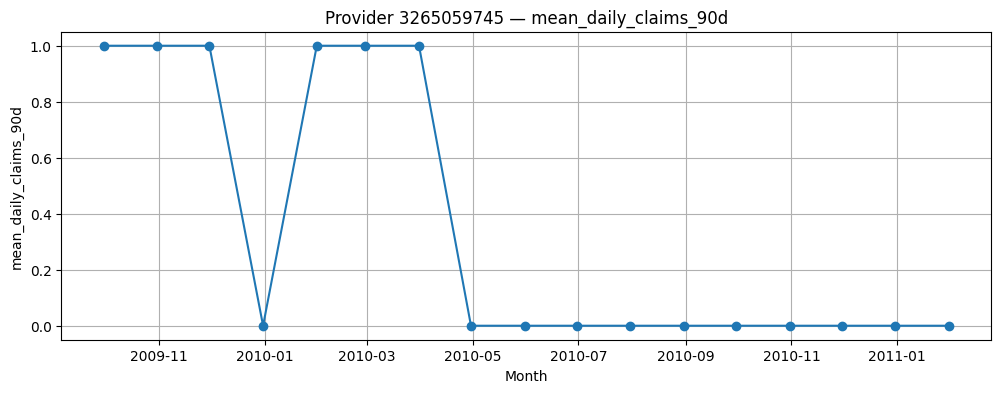

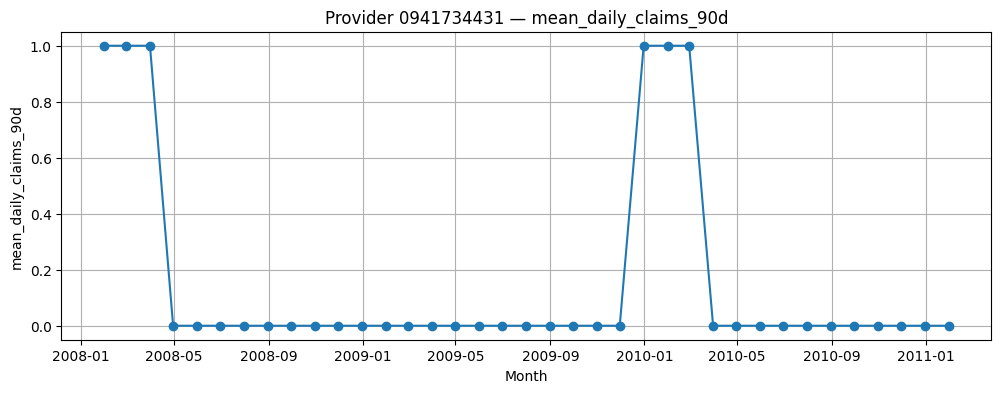

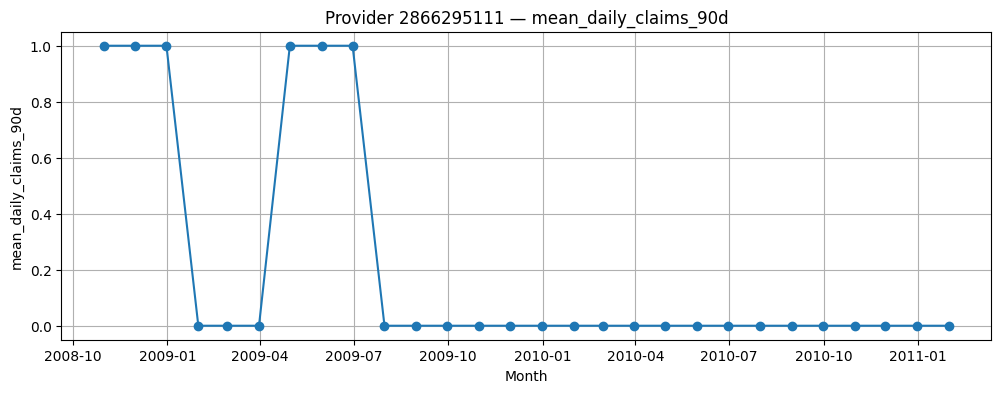

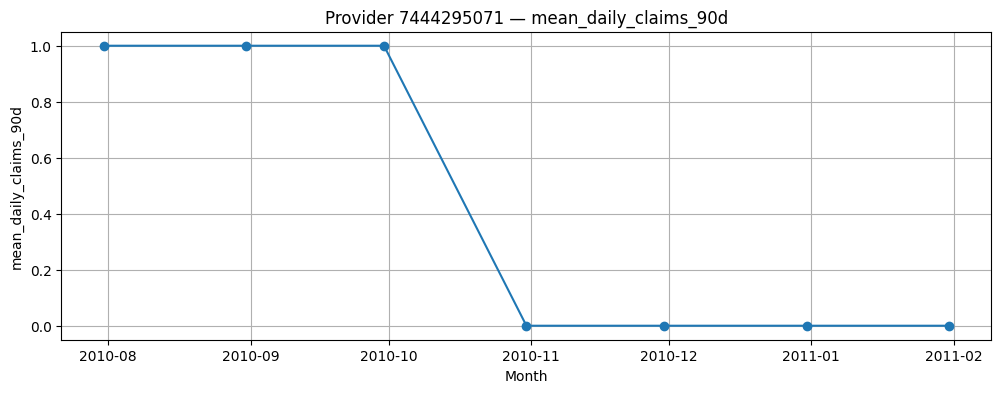

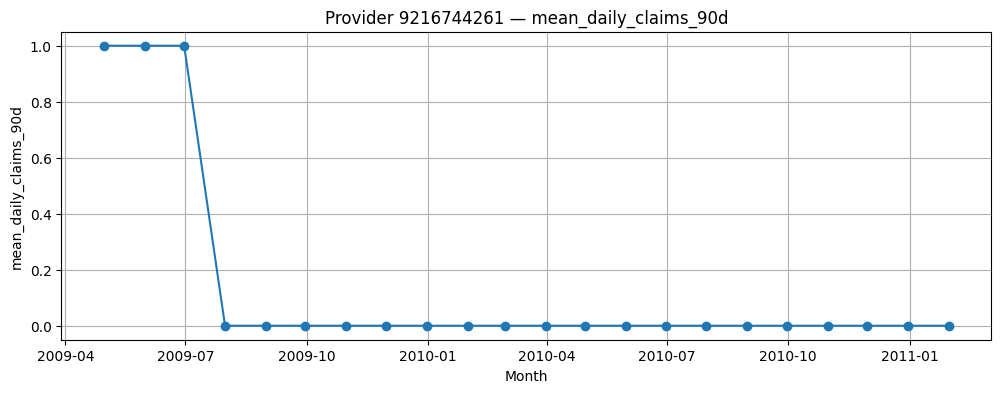

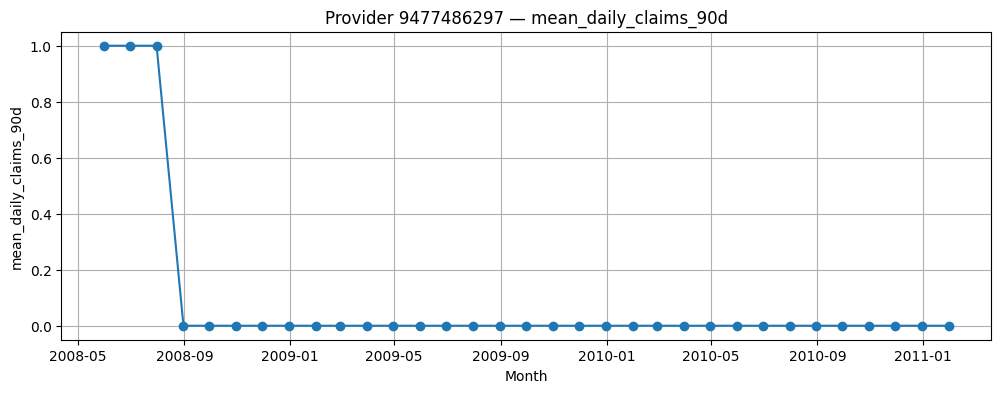

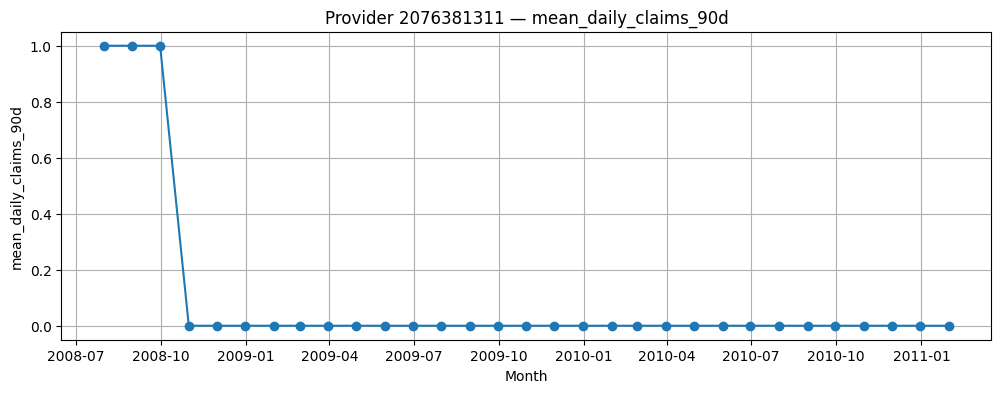

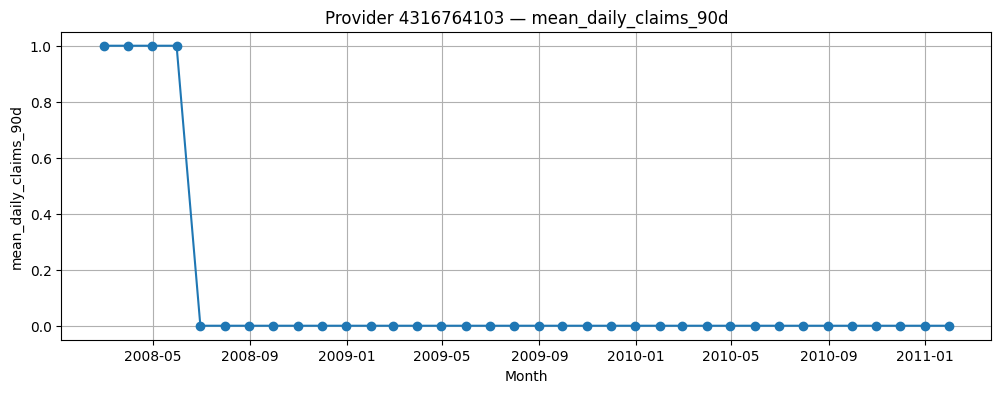

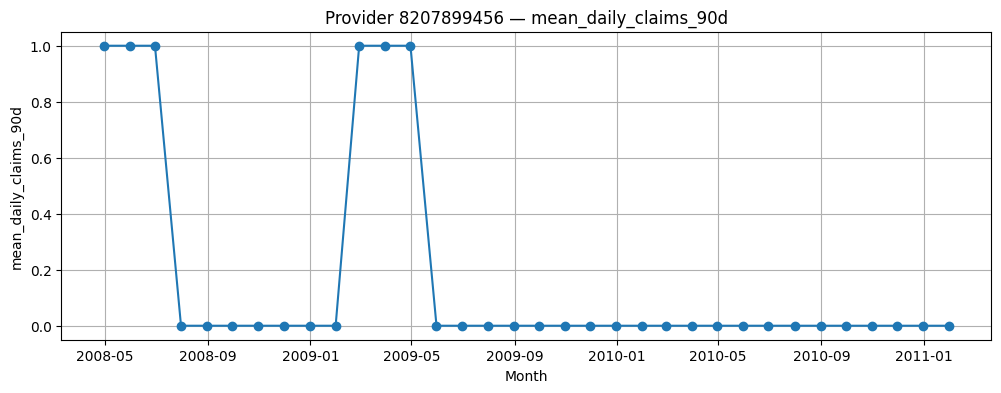

In [23]:
# Plot anomalies (using your existing plotting utils)
from healthcare_signals.plotting_utils import plot_provider_trend

top_sigs = panel.groupby("provider_id")['anomaly_total_flags'].max().sort_values(ascending=False).head(10)

for pid in top_sigs.index:
    df_pid = panel[panel.provider_id == pid].rename(columns={"as_of_date": "snapshot_dt"})
    plot_provider_trend(df_pid, value_col="mean_daily_claims_90d")
